In [1]:
import functools
from collections.abc import Callable, Iterable
from dataclasses import dataclass
from numbers import Number
from typing import Any

import cma
import numpy as np
import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [2]:
%load_ext line_profiler
%load_ext cProfile

The cProfile module is not an IPython extension.


In [3]:
f = functools.partial(
    cma.ff.elli,
    cond=1e5,
    rot=1,
    # cond=1e10,
)  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = 4 * [0]  # initial solution
sigma0 = 1  # initial standard deviation to sample new solutions
pop_size = 10

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 4 (seed=219303, Thu Oct 23 04:26:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 4.409970920645619e+02 1.0e+00 9.44e-01  9e-01  1e+00 0:00.0
    2     20 2.522396110810020e+03 1.3e+00 8.74e-01  8e-01  9e-01 0:00.0
    3     30 9.777828315759469e+02 1.5e+00 6.67e-01  5e-01  7e-01 0:00.0
  100   1000 4.725337882353684e-08 3.5e+02 8.44e-04  5e-05  1e-04 0:00.1
  146   1460 1.046532944166714e-14 3.0e+02 3.73e-06  2e-08  4e-08 0:00.1
termination on tolfun=1e-11
final/bestever f-value = 1.046533e-14 1.046533e-14 after 1460/1458 evaluations
incumbent solution: [ 3.50626472e-08, 2.50927797e-08, -4.60230706e-08, -1.93477181e-08]
std deviation: [3.49004806e-08, 2.52997267e-08, 4.48722059e-08, 2.13206426e-08]


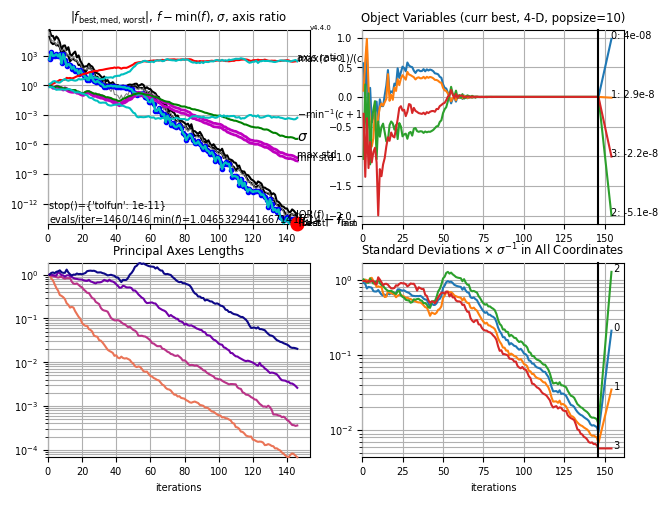

In [4]:
opts = cma.CMAOptions()
opts.set("popsize", pop_size)
es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
history_cma = []
while not es.stop():
    X = es.ask()
    F = [f(x) for x in X]
    history_cma.append(es.best.f)
    es.tell(X, F)
    es.disp()
    es.logger.add()  # write data for plotting
es.result_pretty()
es.plot();  # see below

In [5]:
from numpy import array, dot, outer, trace
from numpy.linalg import norm
from scipy.linalg import expm
from scipy.special import gamma

In [6]:
def natural_evolution_ref(
    f: Callable[[np.ndarray], float],
    x0: np.ndarray,
    population_size: int | None = None,
    eta_mu: float = 1.0,
    eta_cov: float = 1.0,
) -> Iterable[tuple[np.ndarray, float]]:
    d = len(x0)

    if population_size is None:
        population_size = 4 + int(3 * np.log(d))

    mu = np.array(x0, dtype=float)
    E = np.eye(d)
    B = E
    Bi = E
    rng = np.random.default_rng(42)
    weights_limit = np.log(0.5 * population_size + 1)
    weights = np.array([weights_limit - np.log(1 + i) for i in range(population_size)])
    weights = np.maximum(0, weights)
    weights /= np.sum(weights)
    weights -= 1 / population_size
    mu_eff = (norm(weights, ord=1) / norm(weights, ord=2)) ** 2
    path = np.zeros_like(mu)
    path2 = np.zeros_like(mu)
    eta_path = 2 / (1 + population_size)
    2 / (1 + population_size**2)
    path_factor = np.sqrt(eta_path * (2 - eta_path) * mu_eff)
    path_expectation = np.sqrt(2) * gamma((d + 1) / 2) / gamma(d / 2)

    while True:
        z = rng.normal(0, 1, (d, population_size))
        x = mu[:, np.newaxis] + B @ z
        fx = np.array(list(map(f, x.T)))
        ranking = fx.argsort()
        samples = z[:, ranking]
        yield x, fx
        d_mu = samples @ weights
        covGradient = dot(array([outer(s, s) - E for s in samples.T]).T, weights)
        dA = 0.5 * eta_cov * covGradient
        path = (1 - eta_path) * path + path_factor * d_mu
        dA += eta_path * (norm(path) / path_expectation - 1) * E
        path2 = (1 - eta_path) * path2 + path_factor * (B @ d_mu)
        Bi @ path2
        # dA += eta_r1 * outer(u, u) # does not always work - maybe due to coupling of B and sigma
        mu += eta_mu * B @ d_mu
        B = B @ expm(dA)
        Bi = expm(-dA) @ Bi

In [7]:
history_xnes = []
for _x, fx in natural_evolution_ref(f, x0, population_size=pop_size):
    fmin = fx.min()
    if fmin < 1e-20:
        break
    history_xnes.append(fmin)

In [8]:
def natural_evolution(
    f: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float | np.ndarray = 1.0,
    population_size: int | None = None,
    eta_mu: float = 1.0,
    eta_sigma: float = 1.0,
    eta_cov: float = 1.0,
    path_damping: float = 1.0,
    tol_sigma_log: float = -20.0,
) -> Iterable[tuple[np.ndarray, float]]:
    # check parameters
    x0 = np.asarray(x0, dtype=float)
    d = x0.size
    E = np.eye(d)
    if isinstance(sigma0, Number):
        sigma0 = np.full(d, sigma0, dtype=float)
    if sigma0.ndim == 1:
        sigma0 = np.diag(sigma0)
    if population_size is None:
        population_size = 4 + int(3 * np.log(d))

    # construct monotonically decreasing weights
    weights = np.array([np.log1p(population_size / 2) - np.log1p(i) for i in range(population_size)])
    weights = np.maximum(0, weights)
    weights /= np.sum(weights)  # weights should sum to 1
    weights -= 1 / population_size  # subtract baseline for active adaptation
    mu_eff = (norm(weights, ord=1) / norm(weights, ord=2)) ** 2

    # initialize variables
    mu = x0
    sigma = abs(np.linalg.det(sigma0)) ** (1 / d)
    sigma_log = np.log(sigma)
    covariance_sqrt = sigma0 / sigma
    covariance_sqrt_inv = np.linalg.inv(covariance_sqrt)
    path = np.zeros_like(mu)
    path2 = np.zeros_like(mu)
    eta_path = 2 / (1 + population_size)
    eta_r1 = 2 / (1 + population_size**2)
    path_factor = np.sqrt(eta_path * (2 - eta_path) * mu_eff)
    norm_path_expectation = np.sqrt(2) * gamma((d + 1) / 2) / gamma(d / 2)
    rng = np.random.default_rng(42)

    while sigma_log > tol_sigma_log:
        # sample distribution
        sigma = np.exp(sigma_log)
        z = rng.normal(0, 1, (d, population_size))
        x = mu[:, np.newaxis] + sigma * covariance_sqrt @ z

        # evaluate and report
        fx = np.array(list(map(f, x.T)))
        samples = z[:, fx.argsort()]
        yield x, fx

        # calculate natural gradient
        delta_grad = samples @ weights

        # adapt step size
        path = (1 - eta_path) * path + path_factor * delta_grad
        sigma_log += path_damping * eta_path * (norm(path) / norm_path_expectation - 1)

        # rank 1 update
        path2 = (1 - eta_path) * path2 + path_factor * (covariance_sqrt @ delta_grad)
        u = covariance_sqrt_inv @ path2
        rank1_update = eta_r1 * outer(u, u)

        M_grad = array([outer(s, s) - E for s in samples.T]).T @ weights
        M_grad += rank1_update
        sigma_grad = trace(M_grad) / d

        # take update step
        mu += eta_mu * sigma * covariance_sqrt @ delta_grad
        sigma_log += 0.5 * eta_sigma * sigma_grad
        covariance_update = 0.5 * eta_cov * (M_grad - sigma_grad * E)
        covariance_sqrt = covariance_sqrt @ expm(covariance_update)
        covariance_sqrt_inv = expm(-covariance_update) @ covariance_sqrt_inv

In [9]:
history_ines = []
for _x, fx in natural_evolution(f, x0, sigma0, population_size=pop_size):
    # print(fx.min())
    history_ines.append(fx.min())

In [10]:
def natural_evolution_1(
    f: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float = 1.0,
    eta: float = 1.0,
    tol_sigma_log: float = -30.0,
) -> Iterable[tuple[np.ndarray, float]]:
    x0 = np.asarray(x0, dtype=float)
    d = x0.size
    mu = x0
    f_min = np.inf
    log_sigma = np.log(sigma0)
    history_length = d * d
    history = np.zeros((history_length, d), dtype=float)
    history_index = 0
    rng = np.random.default_rng(42)

    while log_sigma > tol_sigma_log:
        s = rng.normal(0, 1, d)
        As = s + history.T @ (history @ s)
        z = np.exp(log_sigma) * As + mu
        fz = f(z)

        if fz < f_min:
            mu = z
            f_min = fz
            u, v = -4, 1
            yield mu, f_min
        else:
            u, v = 4 / 5, 0

        a = -(u + v / 4)
        log_sigma += 0.5 * eta * a

        b = v / 4
        ss = dot(s, s)
        c = (np.exp(0.5 * eta * b * ss) - 1) / ss
        history[history_index, :] = s * np.sqrt(c)
        history_index = (history_index + 1) % history_length


# history_xnes1 = []
# for _x, fx in natural_evolution_1(f, x0):
#     print(fx)
#     history_xnes1.append(fx)

# %lprun -f natural_evolution_1 list(natural_evolution_1(f, x0))

In [11]:
go.Figure(
    [
        go.Scatter(name="XNES", x=list(range(len(history_ines))), y=history_ines),
        go.Scatter(name="XNES-ref", x=list(range(len(history_xnes))), y=history_xnes),
        go.Scatter(name="CMA-ES", x=list(range(len(history_cma))), y=history_cma),
        # go.Scatter(name="XNES1", x=list(range(len(history_xnes1))), y=history_xnes1),
    ]
).update_yaxes(type="log").update_xaxes(type="log")

In [12]:
import cocoex

cocoex.known_suite_names

['bbob',
 'bbob-biobj',
 'bbob-biobj-ext',
 'bbob-boxed',
 'bbob-constrained',
 'bbob-largescale',
 'bbob-mixint',
 'bbob-biobj-mixint',
 'bbob-noisy']

In [ ]:
import cocoex  # experimentation module
import scipy  # to define the solver to be benchmarked


@dataclass
class CocoConfig:
    name: str
    solve_fn: Callable[[cocoex.Problem], Any]


suite_name = "bbob"
suite = cocoex.Suite(suite_name, "", "")

configurations = [
    # CocoConfig("nes-ref", lambda p: list(natural_evolution_ref(p, p.initial_solution, population_size=pop_size))),
    CocoConfig("nes", lambda p: list(natural_evolution(p, p.initial_solution, population_size=pop_size))),
    CocoConfig("fmin", lambda p: scipy.optimize.fmin(p, p.initial_solution, disp=False)),
    CocoConfig("cma", lambda p: cma.fmin2(p, p.initial_solution, 1.0, options=dict(verbose=-9, popsize=pop_size))),
]

for configuration in configurations:
    ### prepare
    options = f"result_folder: {configuration.name}"
    observer = cocoex.Observer(suite_name, options)

    for problem in tqdm(suite, desc=configuration.name):
        problem.observe_with(observer)
        configuration.solve_fn(problem)

cma:   0%|          | 0/2160 [00:00<?, ?it/s]

fmin:   0%|          | 0/2160 [00:00<?, ?it/s]

nes-ref:   0%|          | 0/2160 [00:00<?, ?it/s]

C:\Users\volke\AppData\Local\Temp\ipykernel_9756\3031931280.py:49: RuntimeWarning:

overflow encountered in matmul

C:\Users\volke\AppData\Local\Temp\ipykernel_9756\3031931280.py:49: RuntimeWarning:

invalid value encountered in matmul



KeyboardInterrupt: 

In [ ]:
import cocopp

names = [f"exdata/{c.name}" for c in configurations]
cocopp.main(names)

Post-processing (2+)
  Using 2 data sets:
    exdata/fmin
    exdata/nes

Post-processing (2+)
  loading data...


C:\Users\volke\PycharmProjects\phantom-sc2\.venv\Lib\site-packages\cocopp\pproc.py:1603: UserWarning:

settings is an additional attribute.



  Data consistent according to consistency_check() in pproc.DataSet
  using: exdata/fmin
  Data consistent according to consistency_check() in pproc.DataSet
  using: exdata/nes
  Will generate output data in folder ppdata\exdat_exdat_102303h4545
    this might take several minutes.
ECDF runlength ratio graphs...
  done (Thu Oct 23 03:45:51 2025).
ECDF runlength graphs...
  done (Thu Oct 23 03:45:57 2025).
ECDF graphs per noise group...
Loading best algorithm data from refalgs/best2009-bbob.tar.gz ...
  using: C:\Users\volke\PycharmProjects\phantom-sc2\.venv\Lib\site-packages\cocopp\refalgs/best2009-bbob.tar.gz
  done (Thu Oct 23 03:45:57 2025).
  done (Thu Oct 23 03:46:02 2025).
ECDF graphs per function group...
  done (Thu Oct 23 03:46:19 2025).
ECDF graphs per function...
  done (Thu Oct 23 03:47:08 2025).
Generating comparison tables...
  done (Thu Oct 23 03:47:09 2025).
Scatter plots...
  done (Thu Oct 23 03:47:17 2025).
Scaling figures...
  done (Thu Oct 23 03:47:25 2025).
Output 

DictAlg([(('ex/fmin', ''),
          [DataSet(ex/fmin on f1 2-D, settings = ),
           DataSet(ex/fmin on f2 2-D, settings = ),
           DataSet(ex/fmin on f3 2-D, settings = ),
           DataSet(ex/fmin on f4 2-D, settings = ),
           DataSet(ex/fmin on f5 2-D, settings = ),
           DataSet(ex/fmin on f6 2-D, settings = ),
           DataSet(ex/fmin on f7 2-D, settings = ),
           DataSet(ex/fmin on f8 2-D, settings = ),
           DataSet(ex/fmin on f9 2-D, settings = ),
           DataSet(ex/fmin on f10 2-D, settings = ),
           DataSet(ex/fmin on f11 2-D, settings = ),
           DataSet(ex/fmin on f12 2-D, settings = ),
           DataSet(ex/fmin on f13 2-D, settings = ),
           DataSet(ex/fmin on f14 2-D, settings = ),
           DataSet(ex/fmin on f15 2-D, settings = ),
           DataSet(ex/fmin on f16 2-D, settings = ),
           DataSet(ex/fmin on f17 2-D, settings = ),
           DataSet(ex/fmin on f18 2-D, settings = ),
           DataSet(ex/fmin o